Bismillahirrahmanirrahiiim bisaaa lancarrr dan diberi petunjuk aaamiiin

# MultiModal Target Sentiment Analysis - Google Maps Restaurant Reviews

## Import Library

### Install transformers

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.2 MB/s eta 0:00:00


In [2]:
import transformers
from transformers import(
    BertModel,
    BertTokenizer,
    AdamW,
    get_linear_schedule_with_warmup
)
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from collections import defaultdict
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import json
import random

In [3]:
from transformers import logging
logging.set_verbosity_error()

## Permission to Mydrive

In [4]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [5]:
parent_path = "/content/drive/My Drive/Bismillah_Skripsi_Bisa_Amiiin/Final_Data/"
path_v1 = parent_path + "v1_with_stemming/"
path_v2 = parent_path + "v2_without_stemming/"
path_v1_revisi = parent_path + "v1_version_with_stemming_revisi/"
path_v2_revisi = parent_path + "v2_version_without_stemming_revisi/"
path_v2_revisi2 = parent_path + "v2_version_without_stemming_revisi2/"
path_v3 = parent_path + "v3_version_with_stemming_without_stopword/"
path_v3_revisi = parent_path + "v3_version_with_stemming_without_stopword_revisi/"
path_v4 = parent_path + "v4_version_without_stemming_without_stopword/"
path_v4_revisi = parent_path + "v4_version_without_stopwords_without_stemming/"

In [6]:
parent_captions_path = "/content/drive/My Drive/Bismillah_Skripsi_Bisa_Amiiin/captions/"
indo_captions = parent_captions_path + "indonesia/"
eng_captions = parent_captions_path + "english/"

## sub folder path english caption
base_coco = eng_captions + 'base_coco/'
large_coco = eng_captions + 'large_coco/'
# path_captions_v1 = parent_captions_path + "v1_with_stemming/"
# path_captions_v2 = parent_captions_path + "v2_without_stemming/"
# path_captions_v1_revisi = parent_captions_path + "v1_version_with_stemming_revisi/"
# path_captions_v2_revisi = parent_captions_path + "v2_version_without_stemming_revisi/"
# path_captions_v2_revisi2 = parent_captions_path + "v2_version_without_stemming_revisi2/"
# path_captions_v3 = parent_captions_path + "v3_version_with_stemming_without_stopword/"
# path_captions_v3_revisi = parent_captions_path + "v3_version_with_stemming_without_stopword_revisi/"
# path_captions_v4 = parent_captions_path + "v4_version_without_stemming_without_stopword/"
# path_captions_v4_revisi = parent_captions_path + "v4_version_without_stopwords_without_stemming/"

In [7]:
# train_data = "/content/drive/My Drive/absa_data/twitter2015/test.tsv"
# dev_data = "/content/drive/My Drive/absa_data/twitter2015/test.tsv"
# test_data = "/content/drive/My Drive/absa_data/twitter2015/test.tsv"
path_data = path_v3_revisi
train_data = path_data + "train.xlsx"
dev_data = path_data + "validation.xlsx"
test_data = path_data + "test.xlsx"
captions_json = indo_captions + "captions.json"

# HYPER PARAMETER
PRE_TRAINED_MODEL_NAME = "indolem/indobert-base-uncased"
MAX_LEN = 350
BATCH_SIZE = 16
DROPOUT_PROB = 0.13371489294221273
NUM_CLASSES = 3
DEVICE = "cuda:1"
EPOCHS = 10
LEARNING_RATE = 7.206885992548087e-06
ADAMW_CORRECT_BIAS = True
NUM_WARMUP_STEPS = 0
NUM_RUNS = 1
# RANDOM_SEEDS = list(range(NUM_RUNS))
# # # # # # # # # # # # # # # # # # # # #

In [8]:
PRE_TRAINED_MODEL_NAME = "indolem_indobert-base-uncased"
spek_model = str(PRE_TRAINED_MODEL_NAME)+'_'+'lr_'+str(LEARNING_RATE)+'_dropout_'+str(DROPOUT_PROB)+'text_only_v1'
result_train_file_name = 'results_train_per_run_' + spek_model + '.json'
result_test_file_name = 'results_test_per_run_' + spek_model + '.json'
model_name = 'trained_model_' + spek_model + '.pth'
# path_file_drive = 'content/drive/My Drive/Bismillah_Skripsi_Bisa_Amiiin/Running/' + result_file_name

print('spek model : ',spek_model)
print('result train file name : ',result_train_file_name)
print('result test file name : ',result_test_file_name)
print('model name : ', model_name)
# print('path_file_drive : ',path_file_drive)

spek model :  indolem_indobert-base-uncased_lr_7.206885992548087e-06_dropout_0.13371489294221273text_only_v1
result train file name :  results_train_per_run_indolem_indobert-base-uncased_lr_7.206885992548087e-06_dropout_0.13371489294221273text_only_v1.json
result test file name :  results_test_per_run_indolem_indobert-base-uncased_lr_7.206885992548087e-06_dropout_0.13371489294221273text_only_v1.json
model name :  trained_model_indolem_indobert-base-uncased_lr_7.206885992548087e-06_dropout_0.13371489294221273text_only_v1.pth


## Load and Messages the Dataframes

In [9]:
train_df = pd.read_excel(train_data)
dev_df = pd.read_excel(dev_data)
test_df = pd.read_excel(test_data)

In [10]:
#drop column with index 0 by index
train_df.drop(train_df.columns[[0]], axis=1, inplace=True)

In [11]:
#drop column with index 0 by index
dev_df.drop(dev_df.columns[[0]], axis=1, inplace=True)

In [12]:
#drop column with index 0 by index
test_df.drop(test_df.columns[[0]], axis=1, inplace=True)

In [13]:
# Checking train dataframes
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            2160 non-null   object        
 1   review_img_url  2160 non-null   object        
 2   review_rating   2160 non-null   int64         
 3   review_text     2160 non-null   object        
 4   review_date     2160 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 84.5+ KB


,name,review_img_url,review_rating,review_text,review_date
0,Bebek Tepi Sawah Restaurant Ubud,https://lh5.googleusercontent.com/p/AF1QipPgsL...,2,tempat luas juga bersih untuk makan cukup enak...,2022-09-24
1,Bebek Tepi Sawah Restaurant Ubud,https://lh5.googleusercontent.com/p/AF1QipOiXB...,2,suasana yang sejuk dan asri tambah nafsu makan...,2022-03-14
2,Bebek Tepi Sawah Restaurant Ubud,https://lh5.googleusercontent.com/p/AF1QipPiO2...,2,ramai enak cuma entah kenapa ga seeenak dulu p...,2022-04-23
3,Grand Garden Resto & Cafe,https://lh5.googleusercontent.com/p/AF1QipOhLM...,2,nuansa taman dari rumah klasik dengan banyak p...,2019-06-27
4,Koenokoeni Cafe Gallery,https://lh5.googleusercontent.com/p/AF1QipMJKP...,2,various menu dapat welcome drink jamu dan snac...,2022-09-22


In [14]:
# Checking validation dataframes
dev_df.info()
dev_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            270 non-null    object        
 1   review_img_url  270 non-null    object        
 2   review_rating   270 non-null    int64         
 3   review_text     270 non-null    object        
 4   review_date     270 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 10.7+ KB


,name,review_img_url,review_rating,review_text,review_date
0,Kampung Daun Culture Gallery & Cafe,https://lh5.googleusercontent.com/p/AF1QipPYY3...,0,meski buka dengan prokes ketat tempat ini luma...,2021-10-22
1,Sekar Kedhaton Restaurant,https://lh5.googleusercontent.com/p/AF1QipMLaL...,0,pesan yang catat salah tunggu sangat lama bisa...,2022-05-12
2,Konro Karebosi,https://lh5.googleusercontent.com/p/AF1QipMcD4...,0,maaf banget harus kasih bintang tapi jujur kec...,2021-11-12
3,Gudeg Bu Hj. Amad,https://lh5.googleusercontent.com/p/AF1QipPKaD...,0,gudeg enak kerupuk enak telur enak banget,2017-03-28
4,Sindang Reret Restaurant & Catering Karawang,https://lh5.googleusercontent.com/p/AF1QipMMDT...,0,dapat nasi tutuk oncom kasih bonus lalat maaf ...,2021-01-10


In [15]:
# Checking validation dataframes
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            270 non-null    object        
 1   review_img_url  270 non-null    object        
 2   review_rating   270 non-null    int64         
 3   review_text     270 non-null    object        
 4   review_date     270 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 10.7+ KB


,name,review_img_url,review_rating,review_text,review_date
0,Koenokoeni Cafe Gallery,https://lh3.googleusercontent.com/a-/ACNPEu-ee...,0,pertama kali kesini niat hati ingin jamu tamu ...,2022-06-24
1,Pesta Keboen Restoran,https://lh3.googleusercontent.com/a-/ACNPEu8iA...,0,layan kurang ramah masakan biasa saja tidak pu...,2020-09-15
2,Sindang Reret Restaurant & Catering Karawang,https://lh5.googleusercontent.com/p/AF1QipP4yf...,0,restoran sunda turun dan hanya itu cara seluru...,2019-02-21
3,Bebek Bengil,https://lh5.googleusercontent.com/p/AF1QipP8td...,0,bebek krispy dan ga minyak tapi rasa biasa saj...,2022-02-24
4,Gabah Restaurant & Bar,https://lh5.googleusercontent.com/p/AF1QipPZyg...,0,kami dapat batu di makan kami tidak ada kembal...,2018-02-24


## Rename Column in each dataframes

In [16]:
# Rename column name of train_df dataframes
train_df = train_df.rename(
    {
        "review_rating": "sentiment",
        "name": "target",
        "review_img_url": "image_url",
    },
    axis=1,
)

In [17]:
train_df.head()

,target,image_url,sentiment,review_text,review_date
0,Bebek Tepi Sawah Restaurant Ubud,https://lh5.googleusercontent.com/p/AF1QipPgsL...,2,tempat luas juga bersih untuk makan cukup enak...,2022-09-24
1,Bebek Tepi Sawah Restaurant Ubud,https://lh5.googleusercontent.com/p/AF1QipOiXB...,2,suasana yang sejuk dan asri tambah nafsu makan...,2022-03-14
2,Bebek Tepi Sawah Restaurant Ubud,https://lh5.googleusercontent.com/p/AF1QipPiO2...,2,ramai enak cuma entah kenapa ga seeenak dulu p...,2022-04-23
3,Grand Garden Resto & Cafe,https://lh5.googleusercontent.com/p/AF1QipOhLM...,2,nuansa taman dari rumah klasik dengan banyak p...,2019-06-27
4,Koenokoeni Cafe Gallery,https://lh5.googleusercontent.com/p/AF1QipMJKP...,2,various menu dapat welcome drink jamu dan snac...,2022-09-22


In [18]:
# Rename column name of val_df dataframes
val_df = dev_df.rename(
    {
        "review_rating": "sentiment",
        "name": "target",
        "review_img_url": "image_url",
    },
    axis=1,
)

In [19]:
val_df.head()

,target,image_url,sentiment,review_text,review_date
0,Kampung Daun Culture Gallery & Cafe,https://lh5.googleusercontent.com/p/AF1QipPYY3...,0,meski buka dengan prokes ketat tempat ini luma...,2021-10-22
1,Sekar Kedhaton Restaurant,https://lh5.googleusercontent.com/p/AF1QipMLaL...,0,pesan yang catat salah tunggu sangat lama bisa...,2022-05-12
2,Konro Karebosi,https://lh5.googleusercontent.com/p/AF1QipMcD4...,0,maaf banget harus kasih bintang tapi jujur kec...,2021-11-12
3,Gudeg Bu Hj. Amad,https://lh5.googleusercontent.com/p/AF1QipPKaD...,0,gudeg enak kerupuk enak telur enak banget,2017-03-28
4,Sindang Reret Restaurant & Catering Karawang,https://lh5.googleusercontent.com/p/AF1QipMMDT...,0,dapat nasi tutuk oncom kasih bonus lalat maaf ...,2021-01-10


In [20]:
# Rename column name of test_df dataframes
test_df = test_df.rename(
    {
        "review_rating": "sentiment",
        "name": "target",
        "review_img_url": "image_url",
    },
    axis=1,
)

In [21]:
test_df.head()

,target,image_url,sentiment,review_text,review_date
0,Koenokoeni Cafe Gallery,https://lh3.googleusercontent.com/a-/ACNPEu-ee...,0,pertama kali kesini niat hati ingin jamu tamu ...,2022-06-24
1,Pesta Keboen Restoran,https://lh3.googleusercontent.com/a-/ACNPEu8iA...,0,layan kurang ramah masakan biasa saja tidak pu...,2020-09-15
2,Sindang Reret Restaurant & Catering Karawang,https://lh5.googleusercontent.com/p/AF1QipP4yf...,0,restoran sunda turun dan hanya itu cara seluru...,2019-02-21
3,Bebek Bengil,https://lh5.googleusercontent.com/p/AF1QipP8td...,0,bebek krispy dan ga minyak tapi rasa biasa saj...,2022-02-24
4,Gabah Restaurant & Bar,https://lh5.googleusercontent.com/p/AF1QipPZyg...,0,kami dapat batu di makan kami tidak ada kembal...,2018-02-24


In [22]:
# Checking train_df dataframes
train_df

,target,image_url,sentiment,review_text,review_date
0,Bebek Tepi Sawah Restaurant Ubud,https://lh5.googleusercontent.com/p/AF1QipPgsL...,2,tempat luas juga bersih untuk makan cukup enak...,2022-09-24
1,Bebek Tepi Sawah Restaurant Ubud,https://lh5.googleusercontent.com/p/AF1QipOiXB...,2,suasana yang sejuk dan asri tambah nafsu makan...,2022-03-14
2,Bebek Tepi Sawah Restaurant Ubud,https://lh5.googleusercontent.com/p/AF1QipPiO2...,2,ramai enak cuma entah kenapa ga seeenak dulu p...,2022-04-23
3,Grand Garden Resto & Cafe,https://lh5.googleusercontent.com/p/AF1QipOhLM...,2,nuansa taman dari rumah klasik dengan banyak p...,2019-06-27
4,Koenokoeni Cafe Gallery,https://lh5.googleusercontent.com/p/AF1QipMJKP...,2,various menu dapat welcome drink jamu dan snac...,2022-09-22
...,...,...,...,...,...
2155,The Holy Crab,https://lh5.googleusercontent.com/p/AF1QipM_s2...,0,mahal dengan selera yang sangat buruk layan he...,2018-09-30
2156,Taman Santap Rumah Kayu - Summarecon Gading Se...,https://lh5.googleusercontent.com/p/AF1QipMfSa...,0,makan di rumah makan ini harus penuh sabar jan...,2022-04-08
2157,Taman Santap Rumah Kayu - Summarecon Gading Se...,https://lh5.googleusercontent.com/p/AF1QipPM-E...,0,suasana bagus hanya saja terlalu banyak anak k...,2023-01-21
2158,Seafood Ayu,https://lh5.googleusercontent.com/p/AF1QipOpB3...,0,ramai ini restoran sudah makin ga manusiawi da...,2018-10-30


In [23]:
# Checking val_df dataframes
val_df

,target,image_url,sentiment,review_text,review_date
0,Kampung Daun Culture Gallery & Cafe,https://lh5.googleusercontent.com/p/AF1QipPYY3...,0,meski buka dengan prokes ketat tempat ini luma...,2021-10-22
1,Sekar Kedhaton Restaurant,https://lh5.googleusercontent.com/p/AF1QipMLaL...,0,pesan yang catat salah tunggu sangat lama bisa...,2022-05-12
2,Konro Karebosi,https://lh5.googleusercontent.com/p/AF1QipMcD4...,0,maaf banget harus kasih bintang tapi jujur kec...,2021-11-12
3,Gudeg Bu Hj. Amad,https://lh5.googleusercontent.com/p/AF1QipPKaD...,0,gudeg enak kerupuk enak telur enak banget,2017-03-28
4,Sindang Reret Restaurant & Catering Karawang,https://lh5.googleusercontent.com/p/AF1QipMMDT...,0,dapat nasi tutuk oncom kasih bonus lalat maaf ...,2021-01-10
...,...,...,...,...,...
265,tuna house Megamas,https://lh5.googleusercontent.com/p/AF1QipOFO-...,2,buat cinta seafood khusus tuna wajib mampir ya...,2021-03-04
266,Kepiting Cak Gundul,https://lh5.googleusercontent.com/p/AF1QipOdZc...,2,suasana bagus dan asri makan enak ga sempat ng...,2022-11-26
267,Banda Seafood,https://lh5.googleusercontent.com/p/AF1QipN1df...,2,makan di tempat ini rasa sangat enak yang main...,2022-08-28
268,Ikan Bakar Cianjur,https://lh5.googleusercontent.com/p/AF1QipMJGv...,2,ada bagai macam makan bahan dasar ikan di temp...,2020-01-30


In [24]:
# Checking test_df dataframes
test_df

,target,image_url,sentiment,review_text,review_date
0,Koenokoeni Cafe Gallery,https://lh3.googleusercontent.com/a-/ACNPEu-ee...,0,pertama kali kesini niat hati ingin jamu tamu ...,2022-06-24
1,Pesta Keboen Restoran,https://lh3.googleusercontent.com/a-/ACNPEu8iA...,0,layan kurang ramah masakan biasa saja tidak pu...,2020-09-15
2,Sindang Reret Restaurant & Catering Karawang,https://lh5.googleusercontent.com/p/AF1QipP4yf...,0,restoran sunda turun dan hanya itu cara seluru...,2019-02-21
3,Bebek Bengil,https://lh5.googleusercontent.com/p/AF1QipP8td...,0,bebek krispy dan ga minyak tapi rasa biasa saj...,2022-02-24
4,Gabah Restaurant & Bar,https://lh5.googleusercontent.com/p/AF1QipPZyg...,0,kami dapat batu di makan kami tidak ada kembal...,2018-02-24
...,...,...,...,...,...
265,Banda Seafood,https://lh5.googleusercontent.com/p/AF1QipPHvR...,2,ini adalah kali pertama bagi saya untuk makan ...,2022-07-04
266,Seafood Pak Sangklak Semarang,https://lh5.googleusercontent.com/p/AF1QipMGwD...,2,restoran seafood yang legendaris di semarang l...,2019-01-24
267,Banda Seafood,https://lh5.googleusercontent.com/p/AF1QipODKF...,2,makan enak layan ramah dan cepat,2019-05-23
268,Seafood Pak Sangklak Semarang,https://lh5.googleusercontent.com/p/AF1QipMZIS...,2,enak dan nyaman tempat netral netral netral,2022-06-12


## Load the Image Captions

In [25]:
# Load the image captions
with open(captions_json, "r") as f:
  image_captions = json.load(f)

In [26]:
jumlah_elemen = len(image_captions)
print('Jumlah captions = ',jumlah_elemen)

Jumlah captions =  2698


In [27]:
# show the image_captions
image_captions

{'https://lh5.googleusercontent.com/p/AF1QipPgsLpuE_LeZ2dppzwSOnUa6CrNWUpB6ncEQB9B': 'sekelompok orang duduk mengelilingi meja makan makanan',
 'https://lh5.googleusercontent.com/p/AF1QipOiXB35Rr5sDhGbmHYtzLiUwId94TC-Kc6HfmDo': 'meja dan kursi di teras di bawah atap',
 'https://lh5.googleusercontent.com/p/AF1QipPiO2wZo7YtKY4w1ebhCBbzLHni_jdIs-S_0Ygd': 'seseorang memegang sepiring makanan di tangan mereka',
 'https://lh5.googleusercontent.com/p/AF1QipOhLMQg9gY6y7gfOL4ABpOp9YC39QIwQcOoNkHS': 'menu untuk restoran Cina di atas meja',
 'https://lh5.googleusercontent.com/p/AF1QipMJKPOkCUU2YuZoYhjAatwPzcks4MUMar73cxhH': 'sebuah mobil diparkir di depan gedung putih',
 'https://lh5.googleusercontent.com/p/AF1QipNxEUUHxFs5QpQywm-OGJio01DjubnkRDJ1QwSJ': 'sebuah sepeda motor dan mobil samping di sebuah gedung',
 'https://lh5.googleusercontent.com/p/AF1QipOy7UCxud_CtV_dWAdqNft5N96IcYKH3S08JyqR': 'gelas berisi es dan irisan lemon',
 'https://lh5.googleusercontent.com/p/AF1QipP_My35mSFf12jCBgn039R8GZ

## Build Language Model

In [28]:
# Instantiate the Tokenizer
PRE_TRAINED_MODEL_NAME = "indolem/indobert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

## Construct the Dataset

In [29]:
# # Construct the dataset.
# class RestaurantReviewDataset(Dataset):
#     def __init__(
#         self,
#         reviews: np.array,
#         labels: np.array,
#         sentiment_targets: np.array,
#         image_urls: np.array,
#         review_date : np.array,
#         # image_captions,
#         tokenizer,
#         max_len: int,
#     ):
#         """
#         Downstream code expects reviews and targets to be NumPy arrays.
#         """
#         self.reviews = reviews
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.sentiment_targets = sentiment_targets
#         # self.image_captions = image_captions
#         self.max_len = max_len
#         self.image_urls = image_urls
#         self.review_date = review_date

#     def __len__(self):
#         return len(self.reviews)

#     def __getitem__(self, item):
#         review = str(self.reviews[item])
#         label = self.labels[item]
#         sentiment_target = self.sentiment_targets[item]
#         # try:
#         #     caption = self.image_captions[self.image_ids[item]]
#         # except KeyError:  # A couple of the images have no content.
#         #     caption = ""

#         encoding = self.tokenizer.encode_plus(
#             review,
#             # text_pair=sentiment_target + "." + caption,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             return_token_type_ids=False,
#             padding="max_length",
#             return_attention_mask=True,
#             return_tensors="pt",
#             truncation=True,
#         )

#         return {
#             "review_text": review,
#             "sentiment_targets": sentiment_target,
#             # "caption": caption,
#             "input_ids": encoding["input_ids"].flatten(),
#             "attention_mask": encoding["attention_mask"].flatten(),
#             "targets": torch.tensor(label, dtype=torch.long),
#         }



In [30]:
# Construct the dataset.
class RestaurantReviewDataset(Dataset):
    def __init__(
        self,
        reviews: np.array,
        labels: np.array,
        sentiment_targets: np.array,
        image_urls: np.array,
        review_date : np.array,
        # image_captions,
        tokenizer,
        max_len: int,
    ):
        """
        Downstream code expects reviews and targets to be NumPy arrays.
        """
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.sentiment_targets = sentiment_targets
        # self.image_captions = image_captions
        self.max_len = max_len
        self.image_urls = image_urls
        self.review_date = review_date

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]
        sentiment_target = self.sentiment_targets[item]
        # try:
        #     caption = self.image_captions[self.image_ids[item]]
        # except KeyError:  # A couple of the images have no content.
        #     caption = ""

        encoding = self.tokenizer.encode_plus(
            review,
            # text_pair=sentiment_target + "." + caption,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True,
        )

        return {
            "review_text": review,
            "sentiment_targets": sentiment_target,
            # "caption": caption,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "targets": torch.tensor(label, dtype=torch.long),
        }

## Construct the Data Loader

In [31]:
# # Construct the data loaders.
# def create_data_loader(df, tokenizer, max_len, batch_size, image_captions):
#   ds = RestaurantReviewDataset(
#       reviews = df.review_text.to_numpy(),
#       labels = df.sentiment.to_numpy(),
#       sentiment_targets = df.target.to_numpy(),
#       image_urls = df.image_url.to_numpy(),
#       # image_captions = image_captions,
#       tokenizer = tokenizer,
#       max_len = max_len,
#   )
#   return DataLoader(ds, batch_size = batch_size, num_workers=2)

#   train_data_loader = create_data_loader(
#       train_df, tokenizer, MAX_LEN, BATCH_SIZE, image_captions
#   )

#   val_data_loader = create_data_loader(
#       val_df, tokenizer, MAX_LEN, BATCH_SIZE, image_captions
#   )

#   test_data_loader = create_data_loader(
#       test_df, tokenizer, MAX_LEN, BATCH_SIZE, image_captions
#   )

In [32]:
# # Construct the data loaders.
# def create_data_loader(df, tokenizer, max_len, batch_size):
#   ds = RestaurantReviewDataset(
#       reviews = df.review_text.to_numpy(),
#       labels = df.sentiment.to_numpy(),
#       sentiment_targets = df.target.to_numpy(),
#       image_urls = df.image_url.to_numpy(),
#       review_date = df.review_date.to_numpy(),
#       # image_captions = image_captions,
#       tokenizer = tokenizer,
#       max_len = max_len,
#   )
#   return DataLoader(ds, batch_size = batch_size, num_workers=2)

# train_data_loader = create_data_loader(
#     train_df, tokenizer, MAX_LEN, BATCH_SIZE
# )

# val_data_loader = create_data_loader(
#     val_df, tokenizer, MAX_LEN, BATCH_SIZE
# )

# test_data_loader = create_data_loader(
#     test_df, tokenizer, MAX_LEN, BATCH_SIZE
# )

In [33]:
# Construct the data loaders.
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = RestaurantReviewDataset(
      reviews = df.review_text.to_numpy(),
      labels = df.sentiment.to_numpy(),
      sentiment_targets = df.target.to_numpy(),
      image_urls = df.image_url.to_numpy(),
      review_date = df.review_date.to_numpy(),
      # image_captions = image_captions,
      tokenizer = tokenizer,
      max_len = max_len,
  )
  return DataLoader(ds, batch_size = batch_size, num_workers=2)

train_data_loader = create_data_loader(
    train_df, tokenizer, MAX_LEN, BATCH_SIZE
)

val_data_loader = create_data_loader(
    val_df, tokenizer, MAX_LEN, BATCH_SIZE
)

test_data_loader = create_data_loader(
    test_df, tokenizer, MAX_LEN, BATCH_SIZE
)

In [34]:
train_data_loader

In [35]:
val_data_loader

In [36]:
test_data_loader

## Construct and Instantiate the Classifier

In [37]:
# Construct and instantiate the classifier.
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=DROPOUT_PROB)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    outputs = self.drop(outputs.pooler_output)
    return self.out(outputs)

## Set up the device

In [38]:
# Set up the device
if torch.cuda.is_available():
  device = torch.device(DEVICE)
  print(f"Using {DEVICE}.")
else:
  device = torch.device("cpu")
  print(f"CUDA not available, using CPU.")

Using cuda:1.


## Define train_method : train_epochs

In [39]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device="cuda:0")
    attention_mask = d["attention_mask"].to(device="cuda:0")
    targets = d["targets"].to(device="cuda:0")

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets).item()
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions / n_examples, np.mean(losses)

## Define format output method : format_eval_method

In [40]:
def format_eval_output(rows):
  reviews, targets, labels, predictions = zip(*rows)
  reviews = np.vstack(reviews)
  targets = np.vstack(targets)
  labels = np.vstack(labels)
  predictions = np.vstack(predictions)
  results_df = pd.DataFrame()
  results_df["review"] = reviews.reshape(-1).tolist()
  results_df["target"] = targets.reshape(-1).tolist()
  results_df["label"] = labels
  results_df["prediction"] = predictions
  return results_df

## Define model : eval model

In [41]:
def eval_model(model, data_loader, loss_fn, device, n_examples, detailed_results=False):
  model = model.eval()

  losses = []
  correct_predictions = 0
  rows = []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device="cuda:0")
      attention_mask = d["attention_mask"].to(device="cuda:0")
      targets = d["targets"].to(device="cuda:0")

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds==targets).item()
      losses.append(loss.item())
      rows.extend(
          zip(
              d["review_text"],
              d["sentiment_targets"],
              d["targets"].numpy(),
              preds.cpu().numpy(),
          )
      )

    if detailed_results:
      return(
          correct_predictions/n_examples,
          np.mean(losses),
          format_eval_output(rows),
      )
  return correct_predictions/n_examples, np.mean(losses)

## Fitting the Model

In [42]:
results_per_run = {}
results_training_per_run = {}
counter = 0
list_train_accuracy = []
list_train_loss = []
list_val_accuracy = []
list_val_loss = []
for run_number in range(NUM_RUNS):
  # np.random.seed(RANDOM_SEEDS[run_number])
  # torch.manual_seed(RANDOM_SEEDS[run_number])

  # Setup the model, test it with a single batch.
  data = next(iter(train_data_loader))
  model = SentimentClassifier(NUM_CLASSES)
  model.to(device="cuda:0")
  input_ids = data["attention_mask"].to(device="cuda:0")
  attention_mask = data["attention_mask"].to(device="cuda:0")
  model(input_ids, attention_mask)

  # Configure the Optimizer and scheduler.
  optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=ADAMW_CORRECT_BIAS)
  total_steps = len(train_data_loader) * EPOCHS
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=NUM_WARMUP_STEPS, num_training_steps=total_steps
  )
  loss_fn = nn.CrossEntropyLoss().to(device="cuda:0")

  for epoch in range(EPOCHS):
    counter += 1
    print(f"Epoch {epoch+1}/{EPOCHS} -- RUN {run_number}")
    print("-"*10)
    train_acc, train_loss = train_epoch(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, len(train_df)
    )
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(val_df))
    print(f"Val loss {val_loss} accuracy {val_acc}")
    results_training_per_run[counter] = {
        'train_accuracy' : train_acc,
        'train_loss' : train_loss,
        'val_accuracy' : val_acc,
        'val_loss' : val_loss
    }
  
  test_acc, _, detailed_results = eval_model(
      model, test_data_loader, loss_fn, device, len(test_df), detailed_results=True
  )

  macro_f1 = f1_score(
      detailed_results.label, detailed_results.prediction, average="macro"
  )
  print(f"TEST ACC = {test_acc}\nMACRO F1 = {macro_f1}")

  results_per_run[run_number] = {
      'accuracy' : test_acc,
      'macro-f1' : macro_f1
  }

Epoch 1/10 -- RUN 0
----------


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Train loss 1.2826063226770472 accuracy 0.30462962962962964
Val loss 1.0561927521930021 accuracy 0.46296296296296297
Epoch 2/10 -- RUN 0
----------
Train loss 1.1263870791152673 accuracy 0.36342592592592593
Val loss 0.962459550184362 accuracy 0.5666666666666667
Epoch 3/10 -- RUN 0
----------
Train loss 0.9963994052675035 accuracy 0.5074074074074074
Val loss 0.8280130466994118 accuracy 0.6111111111111112
Epoch 4/10 -- RUN 0
----------
Train loss 0.8807913486604337 accuracy 0.5689814814814815
Val loss 0.7641912242945503 accuracy 0.6555555555555556
Epoch 5/10 -- RUN 0
----------
Train loss 0.7925651382516932 accuracy 0.6449074074074074
Val loss 0.732240708435283 accuracy 0.6851851851851852
Epoch 6/10 -- RUN 0
----------
Train loss 0.7461433896312007 accuracy 0.6652777777777777
Val loss 0.7195699635673972 accuracy 0.6814814814814815
Epoch 7/10 -- RUN 0
----------
Train loss 0.7008960796727075 accuracy 0.6902777777777778
Val loss 0.7171203599256628 accuracy 0.7074074074074074
Epoch 8/10 -- R

In [43]:
path_result_test_file = './' + result_test_file_name
with open(path_result_test_file, 'w+') as f:
  json.dump(results_per_run, f)


print(f"AVERAGE ACC = {np.mean([_['accuracy'] for _ in results_per_run.values()])}")
print(f"AVERAGE MAC-F1 = {np.mean([_['macro-f1'] for _ in results_per_run.values()])}")

AVERAGE ACC = 0.7
AVERAGE MAC-F1 = 0.6906014719743475


In [44]:
path_result_train_file = './' + result_train_file_name
with open(path_result_train_file, 'w+') as f:
  json.dump(results_training_per_run, f)
  

print(f"AVERAGE ACC = {np.mean([_['accuracy'] for _ in results_per_run.values()])}")
print(f"AVERAGE MAC-F1 = {np.mean([_['macro-f1'] for _ in results_per_run.values()])}")

AVERAGE ACC = 0.7
AVERAGE MAC-F1 = 0.6906014719743475


In [45]:
# For download files in colab local directory
from google.colab import files
# name_file = 'results_per_run.json'
files.download(result_test_file_name)
files.download(result_train_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Confusion Matrix

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [47]:
class_names = ['Negative', 'Neutral', 'Positive']

In [48]:
cm = confusion_matrix(detailed_results.label, detailed_results.prediction)

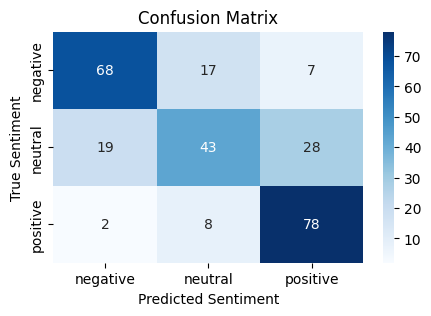

In [49]:
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.show()


## Classification Report

In [50]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
from sklearn.metrics import classification_report

In [52]:
report = classification_report(detailed_results.label, detailed_results.prediction)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.74      0.75        92
           1       0.63      0.48      0.54        90
           2       0.69      0.89      0.78        88

    accuracy                           0.70       270
   macro avg       0.70      0.70      0.69       270
weighted avg       0.70      0.70      0.69       270



In [53]:
target_names = ['negative', 'neutral', 'positive']
report = classification_report(detailed_results.label, detailed_results.prediction, target_names=target_names)
print(report)


              precision    recall  f1-score   support

    negative       0.76      0.74      0.75        92
     neutral       0.63      0.48      0.54        90
    positive       0.69      0.89      0.78        88

    accuracy                           0.70       270
   macro avg       0.70      0.70      0.69       270
weighted avg       0.70      0.70      0.69       270



## Plot Train Accuracy and Validation Accuracy

In [54]:
epochs = list(results_training_per_run.keys())
train_accuracy = [results_training_per_run[epoch]["train_accuracy"] for epoch in epochs]
val_accuracy = [results_training_per_run[epoch]["val_accuracy"] for epoch in epochs]

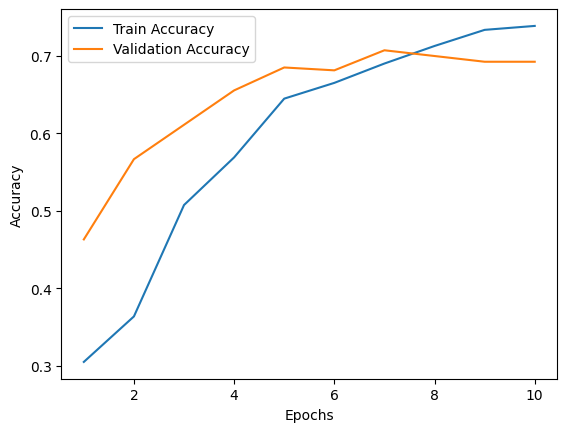

In [55]:
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Save Model to My Drive

In [56]:
# Simpan model
torch.save(model.state_dict(), model_name)

In [57]:
# model_name = "trained_model.pth"
files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
# !pip install PyDrive

In [59]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive

# gauth = GoogleAuth()
# drive = GoogleDrive(gauth)

In [60]:
# gauth.LocalWebserverAuth()

In [61]:
# folder_name = 'Best_Model_Skripsi_Risma'
# folder_id = None

# # Cari ID folder dengan nama "Best_Model_Skripsi_Risma"
# folder_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
# for folder in folder_list:
#     if folder['title'] == folder_name:
#         folder_id = folder['id']
#         break

# print("ID Folder:", folder_id)


In [62]:
# file_path = 'trained_model.pth'  # Ganti dengan path file yang ingin diunggah
# file_title = 'trained_model_MultiligualBERT.pth'  # Ganti dengan nama file yang diinginkan pada Google Drive

# # Unggah file ke folder "Best_Model_Skripsi_Risma"
# file = drive.CreateFile({'title': file_title, 'parents': [{'id': folder_id}]})
# file.SetContentFile(file_path)
# file.Upload()


In [63]:
# # Import library yang dibutuhkan
# from google.colab import files

# # Pilih file yang akan disimpan ke Google Drive
# uploaded = files.upload()
# # path_file = '/content/drive/My Drive/<nama_folder>/<nama_file>'

# # Simpan file ke Google Drive
# for filename in uploaded.keys():
#   with open(path_file_drive, 'wb') as f:
#     f.write(uploaded[filename])
#     print(f"File '{filename}' berhasil disimpan ke Google Drive!")


In [64]:
# # confusionmat_csv_file = '/content/drive/My Drive/Penelitian/ep20lr0003m09confusionmat_xception_100.csv'
# path_file_drive = 'content/drive/My Drive/Bismillah_Skripsi_Bisa_Amiiin/Running/coba/' + result_file_name
# with open(path_file_drive, mode='w') as f:
#     f.write(path_result_file)

In [65]:
# print('Hello WOrld!')